In [ ]:
# default_exp funcs.visualization

In [ ]:
%load_ext autoreload
%autoreload 2

# Visualization tools 

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope, get_roi_filt_inds, mic_inp_apply_inds, extract_psf_roi
from decode_fish.engine.point_process import PointProcessUniform
from matplotlib.backends.backend_agg import FigureCanvas

[autoreload of decode_fish.engine.place_psfs failed: Traceback (most recent call last):
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
cfg = OmegaConf.load(f'../config/experiment/MERFISH_sf_3dvol.yaml')
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


In [ ]:
img_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


In [ ]:
# export
def get_simulation_statistics(decode_dl, micro, int_conc, int_rate, int_loc, int_threshold=1, samples = 1, channels=1, n_bits=1, psf_noise=True, codebook=None):
        
    """
    Draws a sample from the dataloader, and plots a slice of the real volume, the extracted background and
    a slice from a simulated volume.
    """ 
    z_ind = decode_dl.dataset.dataset_tfms[0].crop_sz[0]//2
    with torch.no_grad():
        
        for _ in range(samples):
        
            xmax = 0
            while xmax <= int_threshold:
                x, local_rate, background = next(iter(decode_dl))
                xmax = x[0,0,z_ind].max()
                
            rand_ch = np.random.randint(0,channels)
                
            sim_vars = PointProcessUniform(local_rate[:,0],int_conc, int_rate, int_loc, channels=channels, n_bits=n_bits, sim_z=True,
                                  codebook=codebook, int_option=3).sample(from_code_book=(codebook is not None), phasing=False)
            ch_inp = micro.get_single_ch_inputs(*sim_vars[:-1])
            xsim = micro(*ch_inp, add_noise=psf_noise)
            xsim = micro.noise(xsim, background).sample()
            
            sim_df = sample_to_df(*sim_vars[:5], sim_vars[-1], px_size_zyx=[1.,1.,1.])
            sim_df = sim_df[sim_df['frame_idx'] == 0]
            sim_df = sim_df[sim_df[f'int_{rand_ch}'] > 0]
            
            x = cpu(x[0,rand_ch])
            xsim = cpu(xsim[0,rand_ch])

            if xsim.shape[-3] > 1:
            
                fig, axes = plt.subplots(ncols=3, figsize=(15,5))
                fig.suptitle('z slice', fontsize=15, y=0.96)

                im = axes[0].imshow(x[z_ind])
                add_colorbar(im)
                axes[0].set_title('Recording')

                im = axes[1].imshow(cpu(background[0,rand_ch])[z_ind])
                add_colorbar(im)
                axes[1].set_title('Background')

                im = axes[2].imshow(xsim[z_ind])
                add_colorbar(im)
                axes[2].set_title('Simulation')
                plt.show()

            fig1, axes = plot_3d_projections(x, display=False)
            fig2, axes = plot_3d_projections(xsim, display=False)
            scat_3d_projections(axes, sim_df)
            
            figure = combine_figures([fig1,fig2],[f'Data {rand_ch}','Simulation'], nrows=1, ncols=2, figsize=(20,10))
            figure.suptitle('Max projection', fontsize=15, y=0.9)

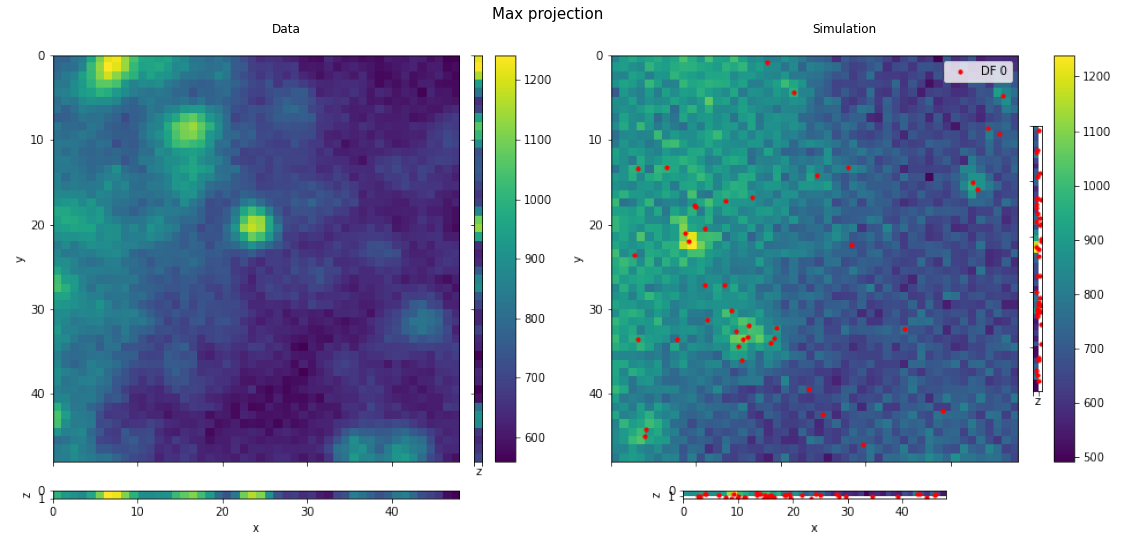

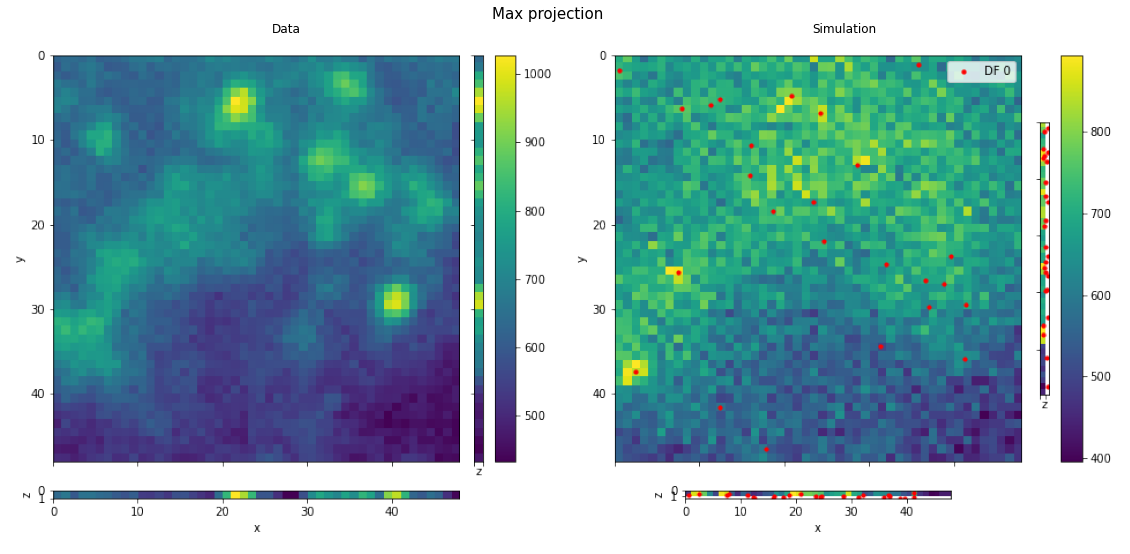

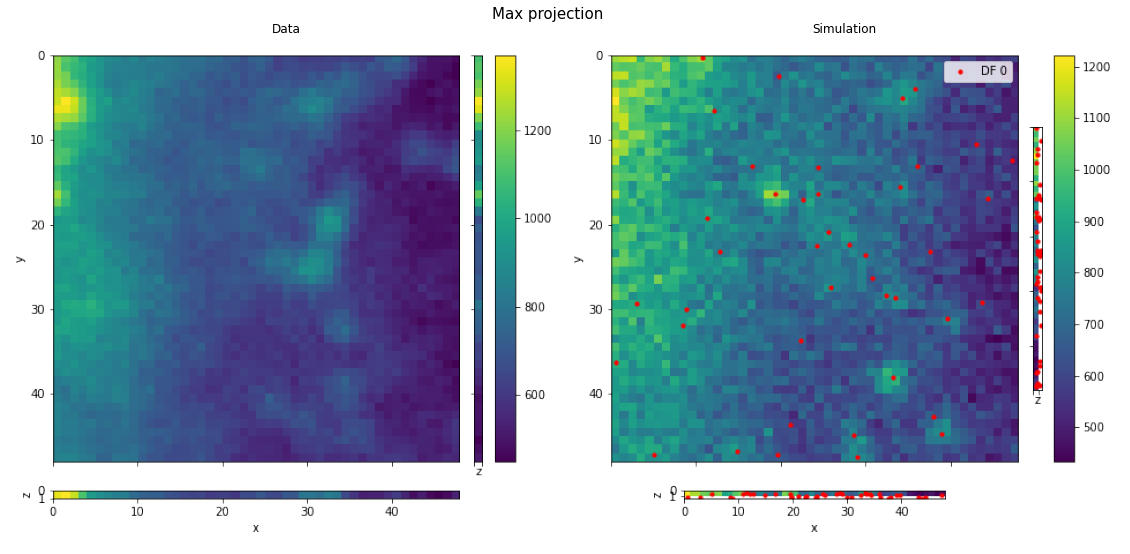

In [ ]:
get_simulation_statistics(decode_dl, micro, **cfg.intensity_dist, int_threshold=10, samples=3, channels=cfg.exp_type.channels, n_bits=cfg.exp_type.n_bits)

In [ ]:
# export
def get_prediction(model, post_proc, img, micro=None, cuda=True, return_rec=False, channel=0):
    
    with torch.no_grad():
        
        img = img[(None,)*(5-img.ndim)]
        model.eval().cuda() if cuda else model.eval().cpu()
        res_dict = model(img.cuda()) if cuda else model(img)
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)
        
        if return_rec:
            micro_inp = post_proc.get_micro_inp(res_dict)
            ch_inp = micro.get_single_ch_inputs(*micro_inp)
            ae_img_3d = micro(*ch_inp)   
            
            filt_inds = get_roi_filt_inds(*ch_inp[0], micro.psf.psf_volume.shape, img.shape, slice_rec=micro.slice_rec, min_dist=10)
            ch_inp = mic_inp_apply_inds(*ch_inp, filt_inds)
            if len(ch_inp[1]):
                psf_recs = micro(*ch_inp, ret_psfs=True, add_noise=False)  
#                         print('N rec inds ', len(psf_recs))

                rois = extract_psf_roi(ch_inp[0], img, torch.tensor(psf_recs.shape))
                psf_bgs = extract_psf_roi(ch_inp[0], res_dict['background'], torch.tensor(psf_recs.shape))
            else: 
                psf_recs = rois = psf_bgs = None
            
            return pred_df, ae_img_3d + res_dict['background'], res_dict, psf_recs, psf_bgs, rois, ch_inp
            
        return pred_df

def eval_random_crop(decode_dl, model, post_proc, micro, proj_func=np.max, cuda=False, samples=1, int_threshold=1, plot='rec', crop_sz_xy=40, ret_preds=False):
    
    with torch.no_grad():
        
        dl_copy = copy.deepcopy(decode_dl)
        dl_copy.dataset.dataset_tfms[0].crop_sz = (dl_copy.dataset.dataset_tfms[0].crop_sz[0], crop_sz_xy, crop_sz_xy)
        
        if ret_preds: samples = 1
        
        for _ in range(samples):
        
            x = torch.zeros(1)
            while x.max() < int_threshold:
                x, local_rate, background = next(iter(dl_copy))
                x = x[:1]
                
            rand_ch = np.random.randint(0, x.shape[1])
            print(rand_ch)
            pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp = get_prediction(model, post_proc, x, micro=micro, cuda=True, return_rec=True, channel=rand_ch)
            pred_df = nm_to_px(pred_df, post_proc.px_size_zyx)
            
            sub_df = pred_df#[code_ref[pred_df['code_inds']][:,rand_ch] > 0]

            x_plot = x[0,rand_ch].cpu().numpy()
            rec = rec[0,rand_ch].cpu().numpy()

            fig1, axes = plot_3d_projections(x_plot, proj_func=proj_func, display=False)
            scat_3d_projections(axes, [sub_df])
            
            if 'res' in plot:

                diff = abs(x_plot-rec)
                fig2, axes = plot_3d_projections(diff, proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'Residual'], figsize=(20,10))
  
            if 'rec' in plot:

                fig2, axes = plot_3d_projections(rec, proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'Reconstruction'], figsize=(20,10))
                
            if 'bg' in plot:

                fig2, axes = plot_3d_projections(res_dict['background'], proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'BG pred.'], figsize=(20,10))
                
            plt.show()
                
        if ret_preds:
            
            return x, local_rate, background, pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp
                        
            
def eval_random_sim(decode_dl, model, post_proc, micro, proj_func=np.max, plot_gt=True, cuda=True, samples=1):
    
    with torch.no_grad():
        
        for _ in range(samples):
        
            x, local_rate, background = next(iter(decode_dl))
            
            sim_vars = PointProcessUniform(local_rate, model.int_dist.int_conc.item(), model.int_dist.int_rate.item(), model.int_dist.int_loc.item()).sample()
            xsim = micro(*sim_vars)
            x = micro.noise(xsim, background).sample()
            pred_df, rec, res_dict = get_prediction(model, post_proc, x[:1], micro=micro, cuda=True, return_rec=True)
            pred_df = nm_to_px(pred_df, post_proc.px_size_zyx)
            sim_df = nm_to_px(sample_to_df(*sim_vars[:-1]))
            sim_df = sim_df[sim_df['frame_idx']==0]

            x = x[0,0].cpu().numpy()
            rec = rec[0,0].cpu().numpy()

            fig1, axes = plot_3d_projections(x, proj_func=proj_func, display=False)
            scat_3d_projections(axes, [pred_df])

            fig2, axes = plot_3d_projections(x, proj_func=proj_func, display=False)

            combine_figures([fig1,fig2], ['Predictions', 'Reconstruction'], figsize=(20,10))

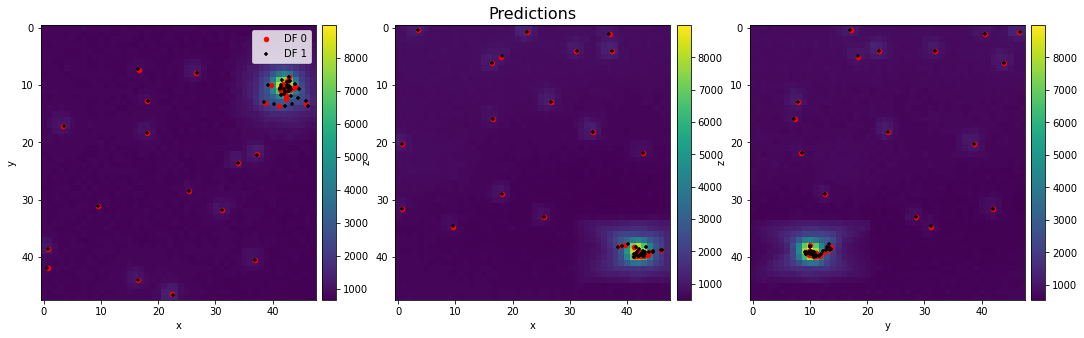

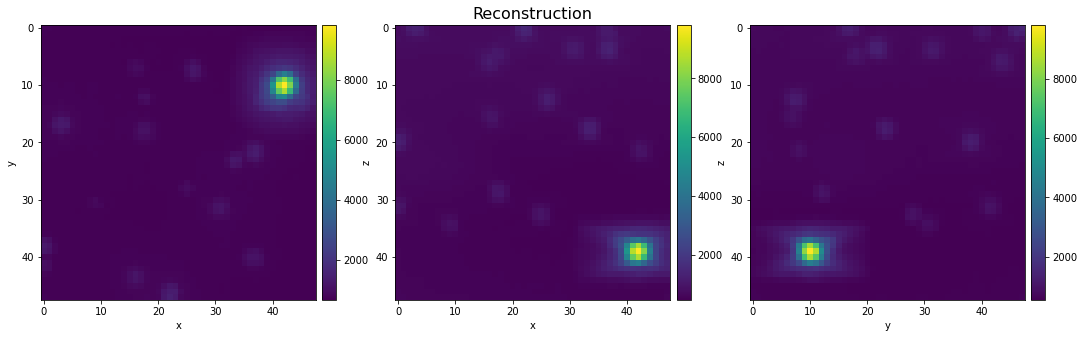

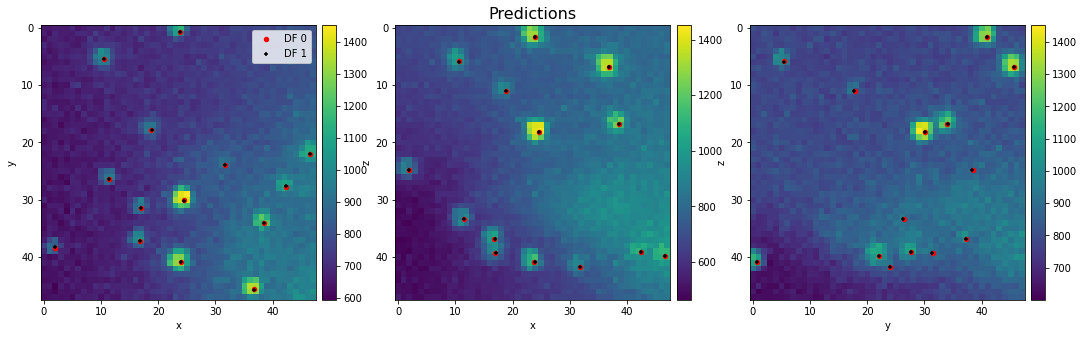

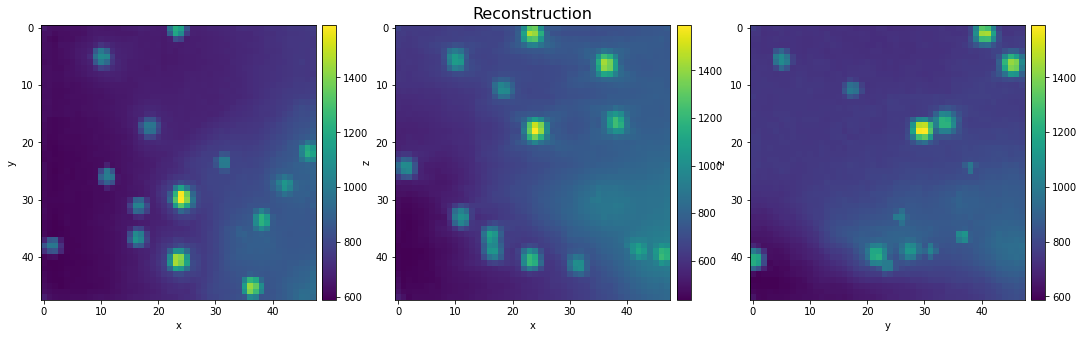

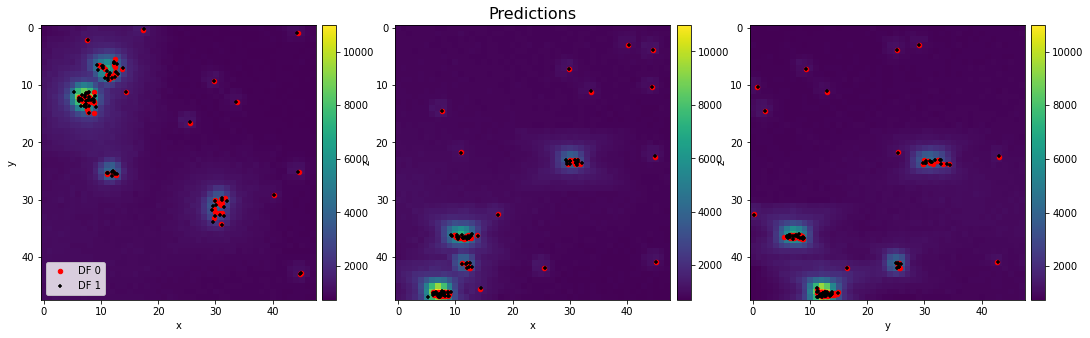

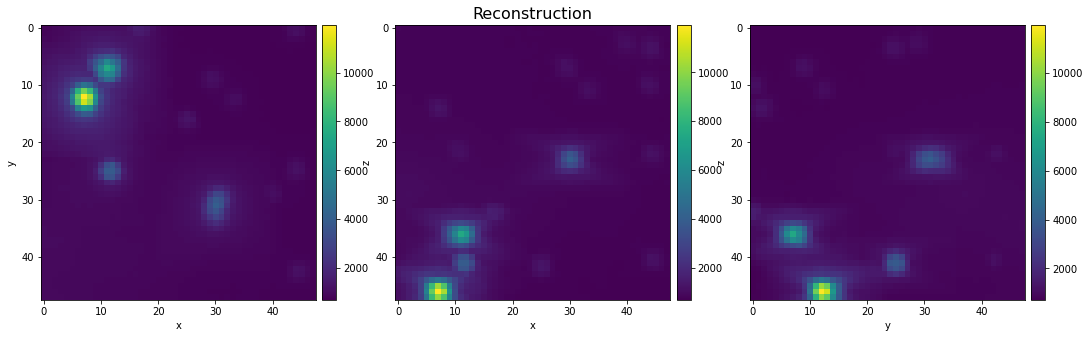

In [ ]:
eval_random_sim(decode_dl, model, post_proc, micro, projection='max', samples=3)

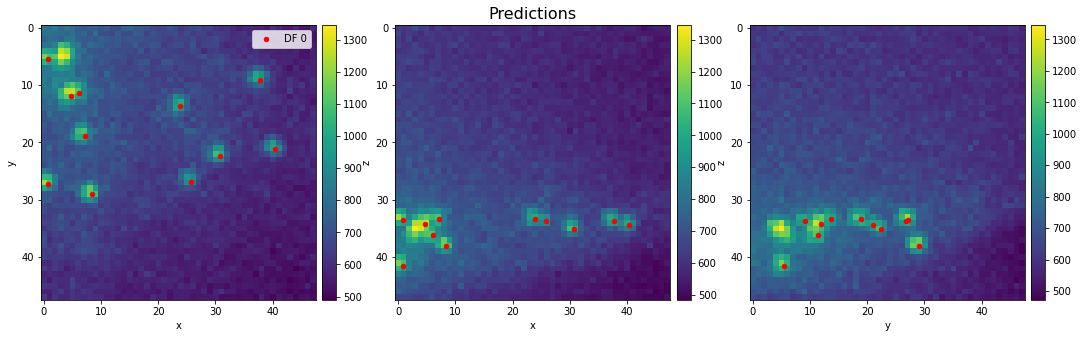

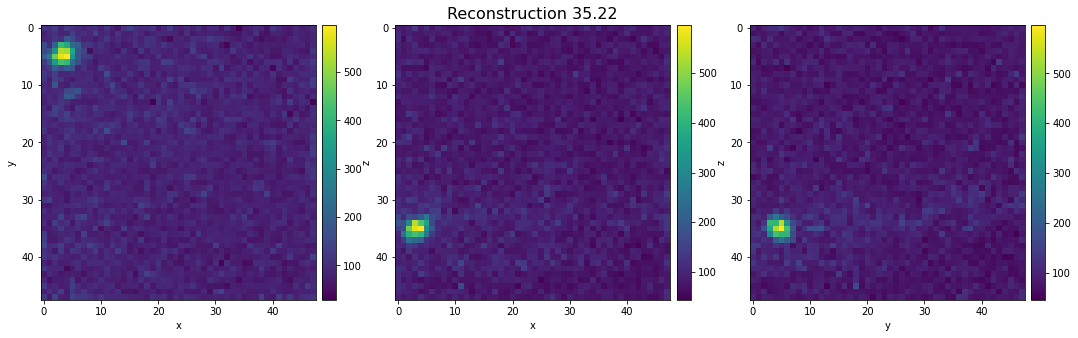

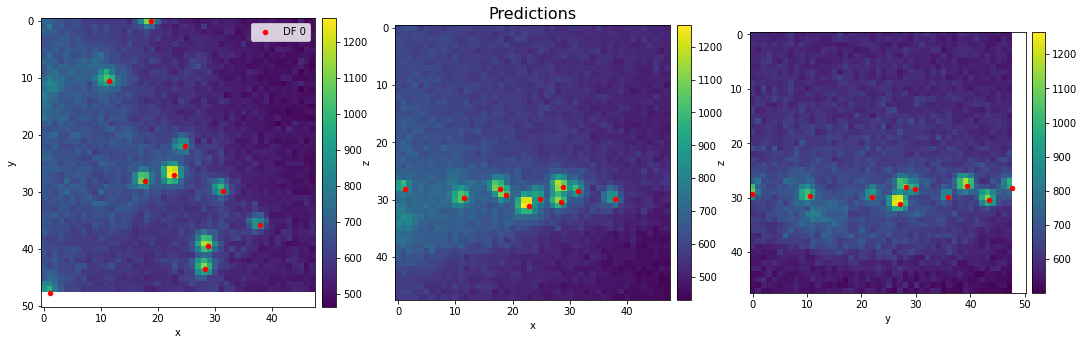

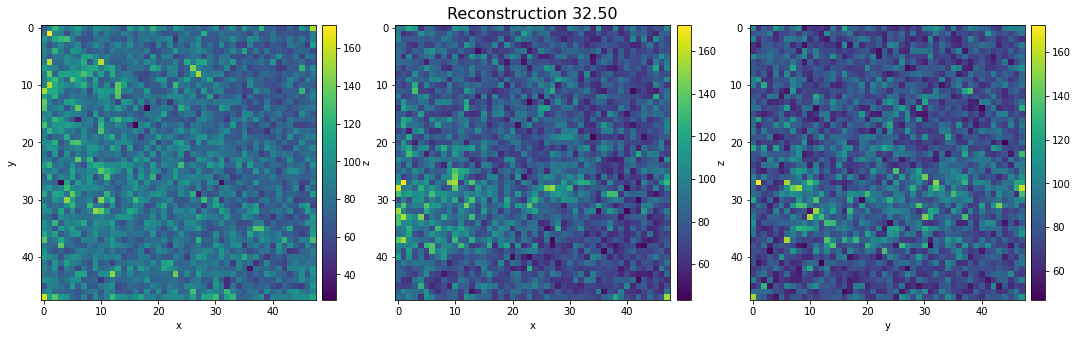

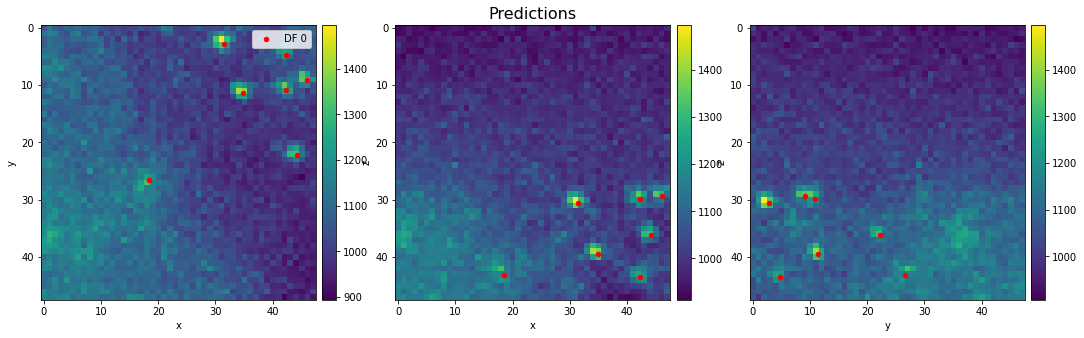

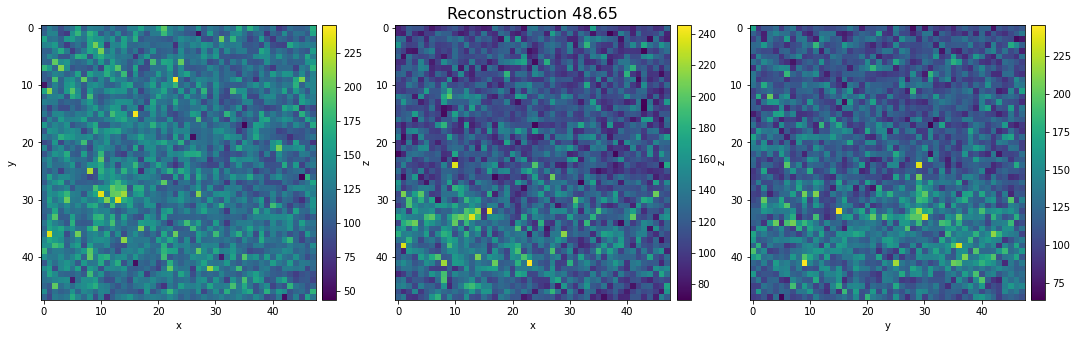

In [ ]:
eval_random_crop(decode_dl, model, post_proc, micro, projection='max', samples=3, int_threshold=1000)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted index.ipynb.
